# How To: Land-Use-Land-Cover Prediction for Slovenia

This notebook server as an example of how to construct and use a machine learning pipeline, from start to finish, to be able to predict the land use for the region of Republic of Slovenia.

The example uses the python package [`eo-learn`](https://github.com/sentinel-hub/eo-learn), a collection of open source Python packages that have been developed to seamlessly access and process spatio-temporal image sequences, acquired by any satellite fleet in a timely and automatic manner.

In this example, we will use satellite images obtained by ESA's Sentinel-2 to train our model and use them for prediction. The example will lead you through the whole process of creating the pipeline, with details provided at each step.

### Requirements

Currently the development version of `eolearn` is needed. 

In order to run the example you'll need a Sentinel Hub account. You can get a trial version [here](https://www.sentinel-hub.com).

Once you have the account set up, login to [Sentinel Hub Configurator](https://apps.sentinel-hub.com/configurator/). By default you will already have the default configuration with an **instance ID** (alpha-numeric code of length 36). For this tutorial it is recommended that you create a new configuration (`"Add new configuration"`) and set the configuration to be based on **Python scripts template**. Such configuration will already contain all layers used in these examples. Otherwise you will have to define the layers for your  configuration yourself.

After you have decided which configuration to use, you have two options You can either put configuration's **instance ID** into `sentinelhub` package's configuration file following the [configuration instructions](http://sentinelhub-py.readthedocs.io/en/latest/configure.html) or you can write it down in the example notebooks.

### Outline of the Example
1. Define the Area-of-Interest (AOI):
   * Obtain the outline of Slovenia (provided)
   * Split into manageable smaller tiles
   * Select a small 3x3 area for classification
2. Use the integrated [`sentinelhub-py`](https://github.com/sentinel-hub/sentinelhub-py) package in order to fill the EOPatches with some content (band data, cloud masks, ...)
   * Define the time interval (this example uses the whole year of 2017)
3. Add additional information from band combinations (norm. vegetation index - NDVI, norm. water index - NDWI)
4. Add a reference map (provided)
   * Convert provided vector data to raster and add it to EOPatches
5. Prepare the training data
   * Remove (or keep) clouds (-> interesting comparison)
   * Perform temporal interpolation (filling gaps and resampling to the same dates)
   * Perform random spatial sampling of the EOPatches
   * Accumulate training info from all EOPatches
   * Split patches for training/validation
6. Construct and train the ML model
7. Validate the model
8. Visualize the results

___________________________________

Let's start!

In [1]:
# Firstly, some necessary imports

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Basics of Python data handling and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from multiprocessing import Pool
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from shapely.geometry import Polygon
import lightgbm as lgb
from sklearn.externals import joblib
from sklearn import metrics
from sklearn import preprocessing

# Basics of GIS
import geopandas as gpd

# The core of this example
from eolearn.core import EOTask, EOPatch, LinearWorkflow, EOWorkflow, FeatureType, Dependency, OverwritePermission, LoadFromDisk, SaveToDisk
from eolearn.io import S2L1CWCSInput
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam

# Misc
import pickle
import sys
import os
import datetime
import itertools
from tqdm import tqdm_notebook as tqdm

# Reference colormap
sys.path.append('../../example_data/')
from lulc_cmap import lulc_cmap, lulc_norm
from lulc_classes import lulc_classes

## 1. Define the Area-of-Interest (AOI):

* The defintion of Slovenia was taken from [here](http://www.naturalearthdata.com/downloads/10m-cultural-vectors/) and buffered a little bit: `example_data/svn_buffered.geojson`
* Convert it to selected CRS: taken to be the CRS of central UTM tile (UTM_33N)
* Split into smaller, manageable, non-overlapping rectangular tiles
* Select a small 3x3 area for classification

### Get country boundary

Dimension of the area is 249870 x 171656 m2


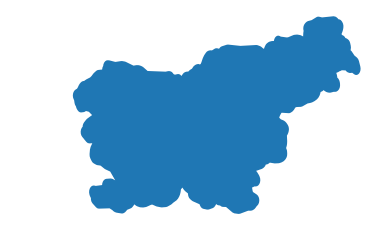

In [2]:
# Load geojson file
country = gpd.read_file('../../example_data/svn_buffered.geojson')

# Convert CRS to UTM_33N
country_crs = CRS.UTM_33N
country = country.to_crs(crs={'init':CRS.ogc_string(country_crs)})

# Get the country's shape in polygon format
country_shape = country.geometry.values.tolist()[-1]

# Plot country
country.plot()
plt.axis('off');

# Print size 
print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(country_shape.bounds[2]-country_shape.bounds[0],country_shape.bounds[3]-country_shape.bounds[1]))

### Split to smaller tiles and choose a 3x3 area

The above size of 249870 x 171656 m2 suggests a rough splitting of 25 (columns) x 17 (rows). However, the splitting choice depends on the available resources of your computer, so two options are presented in the following. A 3x3 EOPatch sample, where each EOPatch has around 1000 x 1000 pixels at 10 meter resolution (~3 GB per EOPatch), or a sample with about 330 x 330 pixels at 10 meter resolution (~300 MB per EOPatch).

Two options are provided, so make a choice.

In [3]:
use_smaller_patches = True

# Create the splitter to obtain a list of bboxes
bbox_splitter_large = BBoxSplitter([country_shape], country_crs, (25, 17))
bbox_splitter_small = BBoxSplitter([country_shape], country_crs, (25*3, 17*3))

bbox_splitter = bbox_splitter_small if use_smaller_patches else bbox_splitter_large

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# Select a central patch
ID = 1549 if use_smaller_patches else 190 # Reference map provided only for this area! You should leave this hardcoded.

# Obtain surrounding patches
patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    if (abs(info['index_x'] - info_list[ID]['index_x']) <= 1 and
        abs(info['index_y'] - info_list[ID]['index_y']) <= 1):
        patchIDs.append(idx)

# Check if final size is 3x3
if len(patchIDs) != 9:
    print('Warning! Use a different central patch ID, this one is on the border.')
    
# Change the order of the patches (used for plotting later)
patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(3,3))).ravel()
    
# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list[patchIDs]]
idxs_x = [info['index_x'] for info in info_list[patchIDs]]
idxs_y = [info['index_y'] for info in info_list[patchIDs]]
df = pd.DataFrame({'index_x':idxs_x, 'index_y':idxs_y})
gdf = gpd.GeoDataFrame(df, 
                       crs={'init':CRS.ogc_string(country_crs)}, 
                       geometry=geometry)

In [4]:
poly = gdf['geometry'][0]
x1,y1,x2,y2 = poly.bounds
aspect_ratio = (y1-y2)/(x1-x2)

### Visualize the selection

(357737.03586605104, 632593.8219180192, 5016135.9977509845, 5204957.80695405)

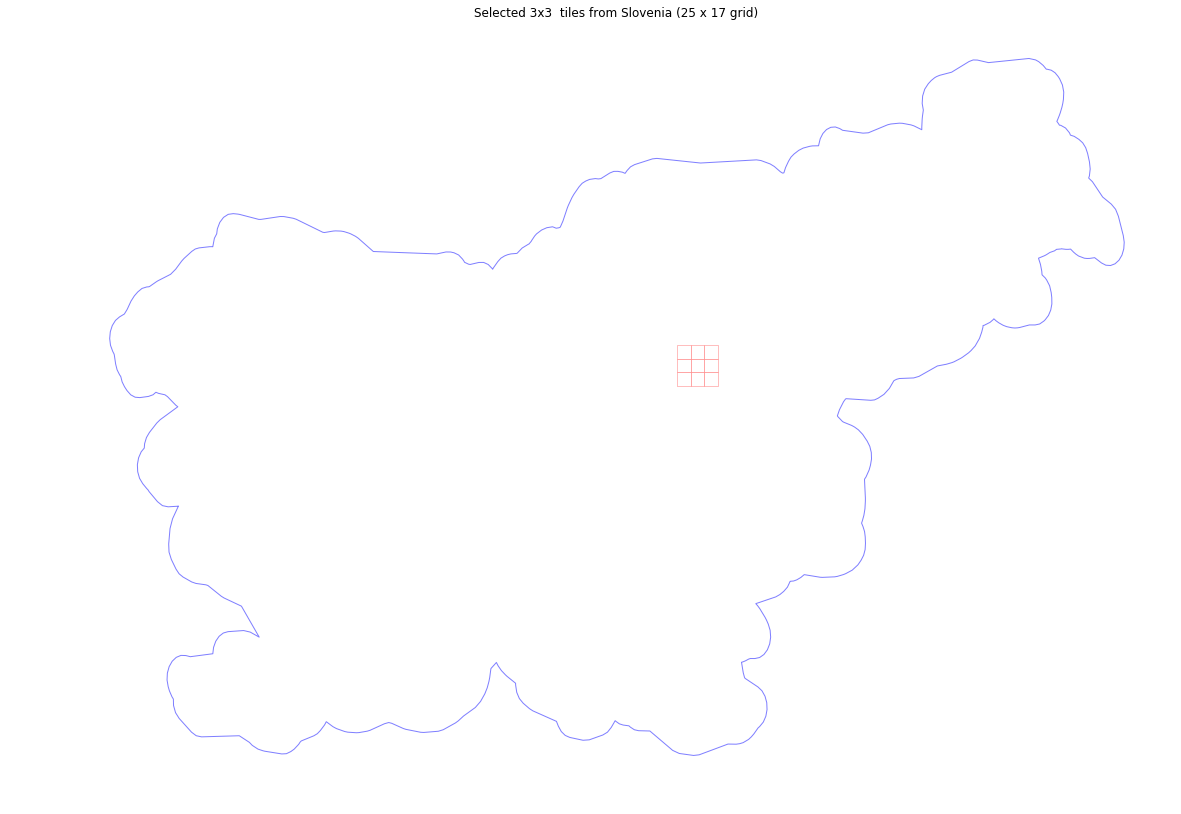

In [5]:
fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 11}

# if bboxes have all same size, estimate offset
xl, yl, xu, yu = gdf.geometry[0].bounds
xoff, yoff = (xu-xl)/3, (yu-yl)/5

# figure
fig, ax = plt.subplots(figsize=(20,20))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
country.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('Selected 3x3  tiles from Slovenia (25 x 17 grid)');
plt.axis('off')

## 2. - 4. Fill EOPatches with data:

Now it's time to create EOPatches and fill them with Sentinel-2 data using Sentinel Hub services. We will add the following data to each EOPatch
* L1C custom list of bands
   * [B02, B03, B04, B08, B11, B12], which corresponds to
   * [B, G, R, NIR, SWIR1, SWIR2]
* SentinelHub's cloud probability map and cloud mask

Additionally, we will add
* Calculated NDVI, NDWI, euclidean NORM information
* Reference maps of the ground truth (government issues, provided for example)
* A mask of validity, based on acquired data from sentinel and cloud coverage
   * Valid pixel is if:
      * IS_DATA == True
      * CLOUD_MASK == 0 (1 indicates that pixel was identified to be covered with cloud)


An EOPatch is created and manipulated using EOTasks, which are chained in an EOWorkflow. In this example the final workflow is executed on all patches, which are saved to the specified directory.

### Define some needed custom EOTasks

In [6]:
class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):        
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool), 
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))
    
class CountValid(EOTask):   
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name
        
    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))
        
        return eopatch


class NormalizedDifferenceIndex(EOTask):   
    """
    The tasks calculates user defined Normalised Difference Index (NDI) between two bands A and B as:
    NDI = (A-B)/(A+B).
    """
    def __init__(self, feature_name, band_a, band_b):
        self.feature_name=feature_name
        self.band_a_fetaure_name=band_a.split('/')[0]
        self.band_b_fetaure_name=band_b.split('/')[0]
        self.band_a_fetaure_idx=int(band_a.split('/')[-1])
        self.band_b_fetaure_idx=int(band_b.split('/')[-1])
        
    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]
        
        ndi = (band_a-band_b)/(band_a+band_b)
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, ndi[...,np.newaxis])
        
        return eopatch

    
class EuclideanNorm(EOTask):   
    """
    The tasks calculates Euclidian Norm of all bands within an array:
    
    norm = sqrt(sum_i Bi**2),
    
    where Bi are the individual bands within user-specified feature array.
    """
    def __init__(self, feature_name, in_feature_name):
        self.feature_name=feature_name
        self.in_feature_name=in_feature_name
    
    def execute(self, eopatch):
        arr = eopatch.data[self.in_feature_name]
        norm = np.sqrt(np.sum(arr**2, axis=-1))
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, norm[...,np.newaxis])
        return eopatch

### Define the workflow tasks

In [7]:
# save to output?
# recommended if you have memory issues
save_choice = True  

# TASK FOR BAND DATA
# add a request for B(B02), G(B03), R(B04), NIR (B08), SWIR1(B11), SWIR2(B12) 
# from default layer 'ALL_BANDS' at 10m resolution
custom_script = 'return [B02, B03, B04, B08, B11, B12];'
add_data = S2L1CWCSInput(
    layer='BANDS-S2-L1C', 
    feature=(FeatureType.DATA, 'BANDS'), # save under name 'BANDS'
    custom_url_params={CustomUrlParam.EVALSCRIPT: custom_script}, # custom url for 6 specific bands
    resx='10m', # resolution x
    resy='10m', # resolution y
    maxcc=0.8, # maximum allowed cloud cover of original ESA tiles
)

# TASK FOR CLOUD INFO
# cloud detection is performed at 160m resolution 
# and the resulting cloud probability map and mask 
# are scaled to EOPatch's resolution
cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=False)
add_clm = AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='160m', cm_size_x='160m', 
                           cmask_feature='CLM', # cloud mask name
                           cprobs_feature='CLP' # cloud prob. map name
                          )

# TASKS FOR CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NORM: sqrt(B02^2 + B03^2 + B04^2 + B08^2 + B11^2 + B12^2)
ndvi = NormalizedDifferenceIndex('NDVI', 'BANDS/3', 'BANDS/2')
ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/1', 'BANDS/3')
norm = EuclideanNorm('NORM','BANDS')

# TASK FOR VALID MASK
# validate pixels using SentinelHub's cloud detection mask and region of acquisition 
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(), 
                                      'IS_VALID' # name of output mask
                                     )

# TASK FOR COUNTING VALID PIXELS
# count number of valid observations per pixel using valid data mask 
count_val_sh = CountValid('IS_VALID', # name of existing mask
                          'VALID_COUNT' # name of output scalar
                         )

# TASK FOR SAVING TO OUTPUT (if needed)
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'
if not os.path.isdir(path_out) and save_choice:
    os.makedirs(path_out)
save = SaveToDisk(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

### Reference map task

For this example, a subset of the country-wide reference for land-use-land-cover is provided. It is provided in the form of a shapefile, which contains polygons and their corresponding labels. The labels represent the following 10 classes:

* lulcid = 0, name = no data
* lulcid = 1, name = cultivated land
* lulcid = 2, name = forest
* lulcid = 3, name = grassland
* lulcid = 4, name = shrubland
* lulcid = 5, name = water
* lulcid = 6, name = wetlands
* lulcid = 7, name = tundra
* lulcid = 8, name = artificial surface
* lulcid = 9, name = bareland
* lulcid = 10, name = snow and ice

The main point of this task is to create a raster mask from the vector polygons and add it to the eopatch. With this procedure, any kind of a labeled shapefile can be transformed into a raster reference map. This result is achieved with the existing task `VectorToRaster` from the `eolearn.geometry` package. All polygons belonging to the each of the classes are separately burned to the raster mask.

In [8]:
raba_path = '../../example_data/raba_subset_small/raba_subset_small.shp' if use_smaller_patches else '../../example_data/raba_subset_large/raba_subset_large.shp'

raba = gpd.read_file(raba_path)

raba_val = [0,1,2,3,4,5,6,7,8,9,10]
raba_array = []
for val in raba_val:
    temp = raba[raba.lulcid==val]
    temp.reset_index(drop=True, inplace=True)
    raba_array.append(temp)
    del temp
    
rshape = (FeatureType.MASK, 'IS_VALID')

raba_task_array = []
for el, val in zip(raba_array, raba_val):
    raba_task_array.append(VectorToRaster(
        feature=(FeatureType.MASK_TIMELESS, 'LULC'), 
        vector_data=el,
        raster_value=val, 
        raster_shape=rshape,
        raster_dtype=np.uint8))

INFO:fiona.ogrext:Failed to auto identify EPSG: 7


### Define the workflow

All the tasks that were defined so far create and fill the EOPatches. The tasks need to be put in some order and executed one by one. This can be achieved by manually executing the tasks, or more conveniently, defining an `EOWorkflow` which does this for you.

The following workflow is created and executed:
1. Create EOPatches with band data
2. Add cloud info
3. Calculate and add NDVI, NDWI, NORM
4. Add mask of valid pixels
5. Add scalar feature representing the cound of valid pixels
6. Add the reference map as a raster
7. Save eopatches

Define the workflow

In [9]:
if save_choice:
    save_task = [save]
else:
    save_task = []

# Define the workflow
workflow = LinearWorkflow(
    add_data,
    add_clm,
    ndvi,
    ndwi,
    norm,
    add_sh_valmask,
    count_val_sh,
    *raba_task_array,
    *save_task
)

_This may take some time, so go grab a cup of coffee ..._

In [10]:
%%time

# Execute the workflow
eopatches = [] # container for the full eopatches
time_interval = ['2017-01-01','2017-12-31'] # time interval for the SH request

# Show progress bar 
pbar = tqdm(total=len(patchIDs))
for idx, bbox in enumerate(bbox_list[patchIDs]):
    # define additional parameters of the workflow
    extra_param = {add_data:{'bbox':bbox, 'time_interval':time_interval}}
    if save_choice:
        extra_param[save] = {'eopatch_folder': 'eopatch_{}'.format(idx)}
    
    result = workflow.execute(extra_param)    
    if save_choice:
        del result
    else:
        eopatches.append(result[list(result.keys())[-1]])
    pbar.update(1)

CPU times: user 1min 15s, sys: 7.97 s, total: 1min 23s
Wall time: 1min 27s


### Visualize the patches and the reference map for all eopatches

Luckily, all patches come from a small region, so all of them have the same dates of acquisition for at least a few dates, so we can inspect the area without interpolation at this point.

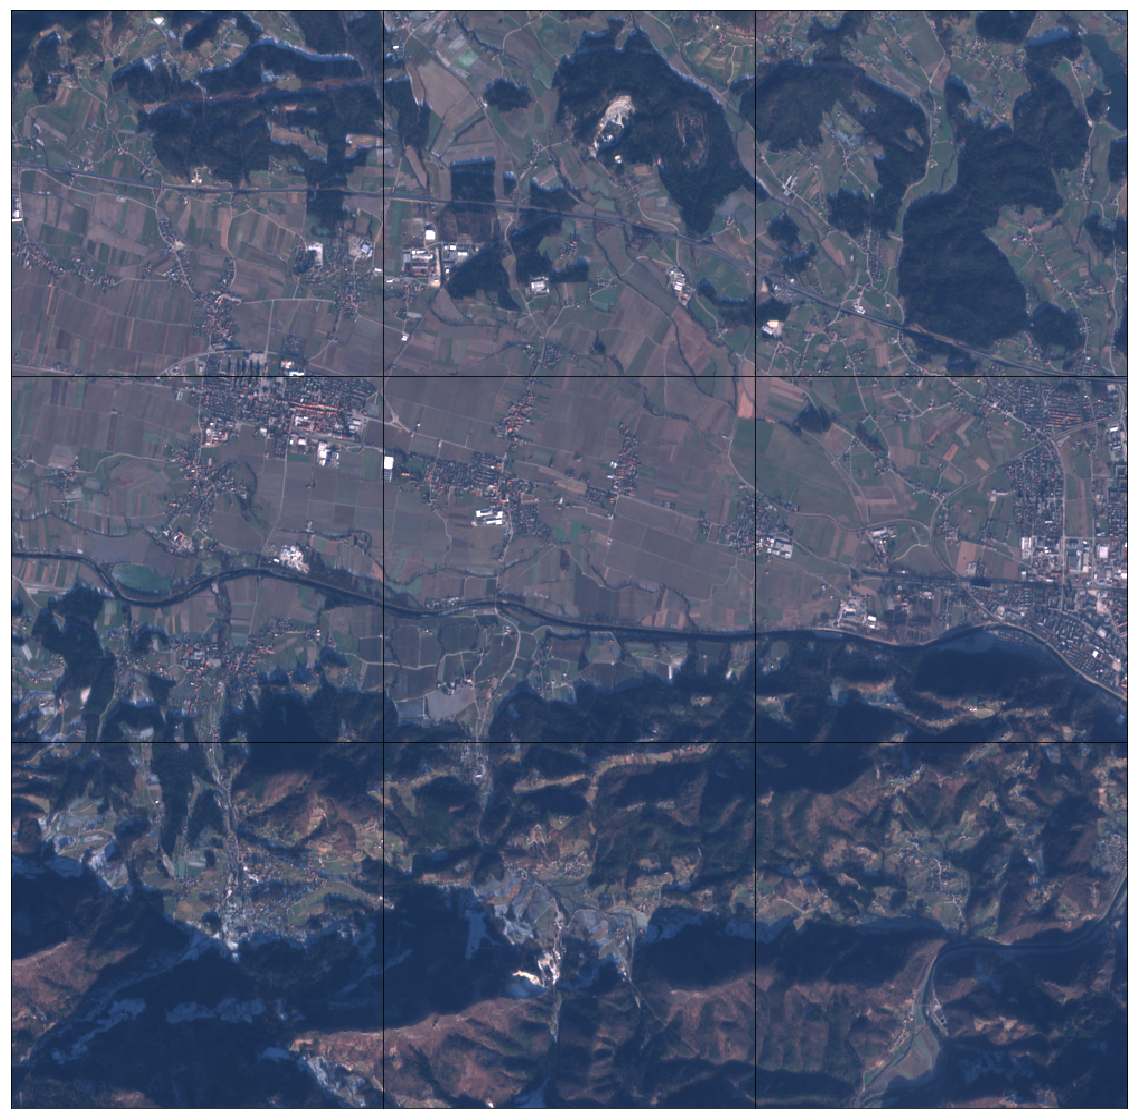

In [11]:
# Draw the RGB image
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'
fig = plt.figure(figsize=(20,20*aspect_ratio))

pbar = tqdm(total=9)
for i in range(9):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i)) if save_choice else eopatches[i]
    ax = plt.subplot(3,3,i+1)
    plt.imshow(np.clip(eopatch.data['BANDS'][0][...,[2,1,0]]*3.5,0,1))
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

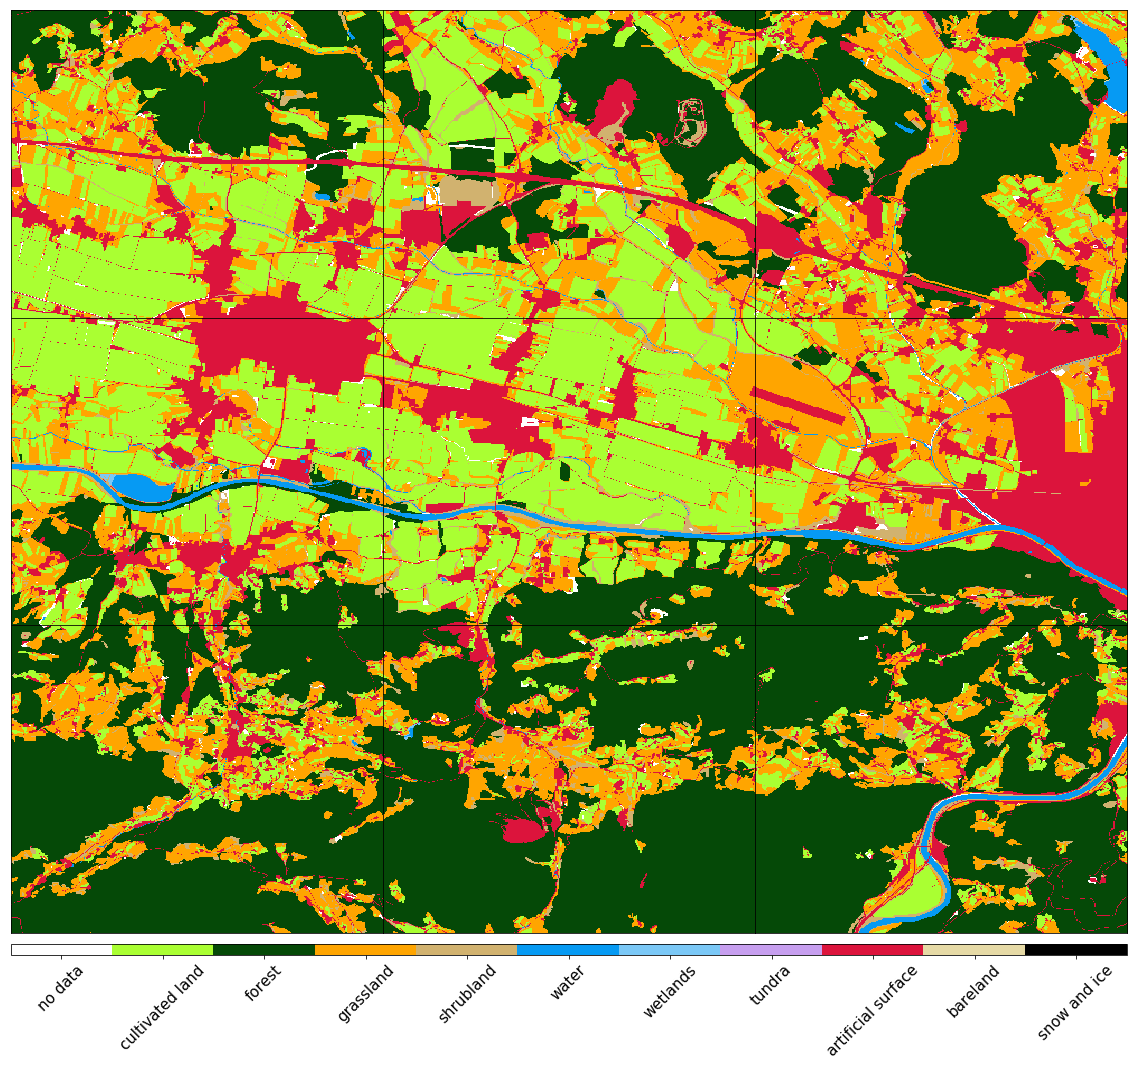

In [12]:
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'

fig, axes = plt.subplots(figsize=(20,20*aspect_ratio), nrows=3, ncols=3)

pbar = tqdm(total=9)
for i, ax in enumerate(axes.flat):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i)) if save_choice else eopatches[i]
    im = ax.imshow(eopatch.mask_timeless['LULC'].squeeze(), cmap=lulc_cmap, norm=lulc_norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad = 0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
cb.set_ticks(np.array(list(lulc_classes.values())))
cb.ax.set_xticklabels(list(lulc_classes.keys()),rotation=45,fontsize=15)
plt.show()

## 5. Prepare the training data

With the patches now created and filled, we can proceed with preparing the training data. The training data preparation is performed in the following way, as already described above:

1. EOTask: Concatenate BAND, NDVI, NDWI, NORM info into a single feature
2. EOTask: Filter out scenes with > 80 % cloud coverage
3. EOTask: Perform temporal interpolation (keep or discard clouds using the mask), resample to specified dates
    * If resampling is used, this creates a new eopatch with only the interpolated features
4. EOTask: Perform random spatial sampling of the EOPatches
5. Due to point 4. we need to copy over some old features from old patches

### Define EOTasks

In [13]:
class LoadFromMemory(EOTask):
    """ 
        Task to load EOPatches to the EOWorkflow from memory
    """
    def execute(self, eopatch):
        return eopatch
    

class ConcatenateData(EOTask):
    """ 
        Task to concatenate data arrays along the last dimension
    """
    def __init__(self, feature_name, feature_names_to_concatenate):
        self.feature_name = feature_name
        self.feature_names_to_concatenate = feature_names_to_concatenate

    def execute(self, eopatch):
        arrays = [eopatch.data[name] for name in self.feature_names_to_concatenate]

        eopatch.add_feature(FeatureType.DATA, self.feature_name, np.concatenate(arrays, axis=-1))

        return eopatch
    
    
class ValidDataFractionPredicate:
    """
    Predicate that defines if a frame from EOPatch's time-series is valid or not. Frame is valid, if the 
    valid data fraction is above the specified threshold.
    """
    def __init__(self, threshold):
        self.threshold = threshold
        
    def __call__(self, array):
        coverage = np.sum(array.astype(np.uint8))/np.prod(array.shape)
        return coverage > self.threshold    
    
    
class MoveFeature(EOTask):
    """
    Task to copy fields from one eopatch to another
    The fields are defined as a dictionary in the form {FeatureType: {feature_names_to_copy}}
    """
    def __init__(self, fields_to_copy):
        self.fields_to_copy = fields_to_copy
        
    def execute(self, *eopatches):
        dst_eopatch, src_eopatch = eopatches
        for key in self.fields_to_copy.keys():
            for name in self.fields_to_copy[key]:
                dst_eopatch.add_feature(key, name, src_eopatch[key][name])
        return dst_eopatch

### Define the workflow tasks

In [14]:
# TASK TO LOAD EXISTING EOPATCHES
load_from_file = LoadFromDisk(path_out, lazy_loading = True)
load_from_memory = LoadFromMemory()

# TASK FOR CONCATENATION
concatenate = ConcatenateData('FEATURES', ['BANDS', 'NDVI', 'NDWI', 'NORM'])

# TASK FOR FILTERING OUT TOO CLOUDY SCENES
# keep frames with > 80 % valid coverage
valid_data_predicate = ValidDataFractionPredicate(0.8)
filter_task = SimpleFilterTask((FeatureType.MASK, 'IS_VALID'), valid_data_predicate)

# TASK FOR LINEAR INTERPOLATION
# linear interpolation of full time-series and date resampling
resampled_range = ('2017-01-01','2017-12-31',16)
linear_interp = LinearInterpolation(
    'FEATURES', # name of field to interpolate
    mask_feature = (FeatureType.MASK,'IS_VALID'), # mask to be used in interpolation
    resample_range=resampled_range, # set the resampling range
    bounds_error=False # extrapolate with NaN's
)

# TASKS FOR MOVING STUFF
move_features = MoveFeature({
    FeatureType.MASK_TIMELESS: {'LULC'},
    FeatureType.MASK: {'IS_VALID'}
})

# TASK FOR EROSION
disk_radius = 1 # size of erosion disk, applied before sampling
erosion = ErosionTask((FeatureType.MASK_TIMELESS, 'LULC'), disk_radius=disk_radius)

# TASK FOR SPATIAL SAMPLING
# Uniformly sample about 100k pixels from patches
n_samples = int(4e4) if use_smaller_patches else int(1e5) # no. of pixels to sample
ref_labels = [0,1,2,3,4,5,6,7,8,9,10] # reference labels to take into account when sampling
spatial_sampling = PointSamplingTask(
    n_samples=n_samples, 
    ref_mask_feature='LULC', 
    ref_labels=ref_labels, 
    sample_features=[  # tag fields to sample
        (FeatureType.DATA, 'FEATURES'), 
        (FeatureType.MASK, 'IS_VALID'),
        (FeatureType.MASK_TIMELESS, 'LULC')
    ])

path_out_sampled = './eopatches_sampled_small/' if use_smaller_patches else './eopatches_sampled_large/'
if not os.path.isdir(path_out_sampled) and save_choice:
    os.makedirs(path_out_sampled)
save = SaveToDisk(path_out_sampled, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [15]:
if save_choice:
    load = load_from_file
    save_dependency = [Dependency(task=save, inputs=[spatial_sampling])]
else:
    load = load_from_memory
    save_dependency = []

# Define the workflow
# In this case the workflow is not linear anymore, 
# specifically because of the "move_features" task, which demands two inputs

workflow = EOWorkflow(dependencies=[
    Dependency(task=load, inputs=[]),
    Dependency(task=concatenate, inputs=[load]),
    Dependency(task=filter_task, inputs=[concatenate]),
    Dependency(task=linear_interp, inputs=[filter_task]),
    Dependency(task=move_features, inputs=[linear_interp, filter_task]),
    Dependency(task=erosion, inputs=[move_features]),
    Dependency(task=spatial_sampling, inputs=[erosion]),
    *save_dependency
])

/home/devis/anaconda3/envs/eo-learn-develop/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Parameter 'transform' has been renamed to 'task' and will soon be removed. Please use parameter 'task' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


### Run the EOWorkflow over all EOPatches

In [16]:
%%time

# Execute the workflow
# Show progress bar 
pbar = tqdm(total=len(patchIDs))
for i in range(9):
    if save_choice:
        result = workflow.execute({
            load: {'eopatch_folder': 'eopatch_{}'.format(i)},
            save: {'eopatch_folder': 'eopatch_{}'.format(i)}
        })
        del result
    else:
        result = workflow.execute({
            load: {'eopatch': eopatches[i]}
        })
        # update old patches
        eopatches[i] = result[list(result.keys())[-1]]
        del result
    pbar.update(1)

CPU times: user 1min, sys: 16.6 s, total: 1min 16s
Wall time: 1min 16s


In [17]:
if save_choice:
    # load sampled eopatches
    eopatches = []
    path_out_sampled = './eopatches_sampled_small/' if use_smaller_patches else './eopatches_sampled_large/'
    
    for i in range(9):
        eopatches.append(EOPatch.load('{}/eopatch_{}'.format(path_out_sampled, i), lazy_loading = True))    

eopatches = np.array(eopatches)

## 6. Model construction and training

In this part we split the eopatches in a training and testing subset, where we take the patch with ID = 1 for testing, since it seems to be a good representative of the land cover. 

The test sample is hand picked because of the small set of patches, otherwise with a larged overall set, the training and testing patches should be randomly chosen.

The sampled features and labels are loaded and reshaped into $n \times m$, where $n$ represents the number of training pixels, and $m = f \times t$ the number of all features, with $f$ the size of bands and band combinations (in this example 11) and $t$ the length of the resampled time-series (in this example 23)

[LightGBM](https://github.com/Microsoft/LightGBM) is used as a ML model. It is a fast, distributed, high performance gradient boosting framework based on decision tree algorithms, used for many machine learning tasks.

The default hyper-parameters are used in this example. For more info on parameter tuning, check the [ReadTheDocs](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html) of the package.

In [18]:
# Definition of the train and test patch IDs
train_ID = [0,2,3,4,5,6,7,8] if use_smaller_patches else [0,1,3,4,5,6,7,8]
test_ID = [1] if use_smaller_patches else [2]

# Set the features and the labels for train and test sets
features_train = np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches[train_ID]])
labels_train = np.array([eopatch.mask_timeless['LULC_SAMPLED'] for eopatch in eopatches[train_ID]])
features_test = np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches[test_ID]])
labels_test = np.array([eopatch.mask_timeless['LULC_SAMPLED'] for eopatch in eopatches[test_ID]])

# rotate dimension so that reshape can be used 
p1, t, w, h, f = features_train.shape
p2, t, w, h, f = features_test.shape
p = p1+p2

# reshape to n x m
features_train = np.swapaxes(features_train,1,3).reshape(p1*h*w, t*f)
labels_train = np.swapaxes(labels_train,1,2).reshape(p1*h*w,1).squeeze()
features_test = np.swapaxes(features_test,1,3).reshape(p2*h*w, t*f)
labels_test = np.swapaxes(labels_test,1,2).reshape(p2*h*w,1).squeeze()

# remove points with no reference from training (so we dont train to recognize "no data")
mask = labels_train == 0
features_train = features_train[~mask]
labels_train = labels_train[~mask]

# remove points with no reference from test (so we dont validate on "no data", which doesn't make sense)
mask = labels_test == 0
features_test = features_test[~mask]
labels_test = labels_test[~mask]

### Set up and train the model

In [19]:
%%time

# Set up training classes
labels_unique = np.unique(labels_train)

# Set up the model
model = lgb.LGBMClassifier(
    objective='multiclass', 
    num_class=len(labels_unique), 
    metric='multi_logloss'
)

# train the model
model.fit(features_train, labels_train)

# uncomment to save the model
model_base = 'model_SI_LULC_smaller' if use_smaller_patches else 'model_SI_LULC_smaller'
joblib.dump(model, './{}_{}.pkl'.format(model_base, datetime.date.today().strftime("%m.%d.%Y")))

CPU times: user 6min 38s, sys: 275 ms, total: 6min 38s
Wall time: 52.4 s


## 7. Validation

Validation of the model is a crucial step in data science. All models are wrong, but some are less wrong than others, so model evaluation is important.

In order to validatet the model, we use the training set to predict the classes, and then compare the predicted set of labels to the "ground truth".

Unfortunately, ground truth in the scope of EO is a term that should be taken lightly. Usually, it is not 100 % reliable due to several reasons:
* Labels are determined at specific time, but land use can change (_what was once a field, may now be a house_)
* Labels are overly generalized (_a city is an artificial surface, but it also contains parks, forests etc._)
* Some classes can have an overlap or similar definitions (_part of a continuum, and not discrete distributions_)
* Human error (_mistakes made when producing the reference map_)

The validation is performed by evaluating various metrics, such as accuracy, precision, recall, $F_1$ score, some of which are nicely described [in this blog post](https://medium.com/greyatom/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b)

In [20]:
# uncomment to load the model
model_path = './model_SI_LULC_smaller_12.19.2018.pkl'
model = joblib.load(model_path)

# predict the test labels
plabels_test = model.predict(features_test)

Get the overall accuracy (OA) and the weighted $F_1$ score

In [21]:
print('Classification accuracy {:.1f}%'.format(100*metrics.accuracy_score(labels_test, plabels_test)))
print('Classification F1-score {:.1f}%'.format(100*metrics.f1_score(labels_test, plabels_test, average='weighted')))

Classification accuracy 92.3%
Classification F1-score 91.9%


$F_1$ score, precision, and recall for each class separately

In [22]:
class_labels = np.unique(labels_test)
class_names = list(lulc_classes.keys())

f1_scores = metrics.f1_score(labels_test, plabels_test, labels=class_labels, average=None)
recall = metrics.recall_score(labels_test, plabels_test, labels=class_labels, average=None)
precision = metrics.precision_score(labels_test, plabels_test, labels=class_labels, average=None) 

print('             Class              =  F1  | Recall | Precision')
print('         --------------------------------------------------')
for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
    print('         * {0:20s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}'.format(lulctype, 
                                                                         f1_scores[idx]*100, 
                                                                         recall[idx]*100, 
                                                                         precision[idx]*100))

             Class              =  F1  | Recall | Precision
         --------------------------------------------------
         * cultivated land      = 94.2 |  93.0  | 95.5
         * forest               = 95.7 |  98.1  | 93.4
         * grassland            = 89.1 |  92.3  | 86.1
         * shrubland            = 38.4 |  26.1  | 72.6
         * water                = 22.2 |  25.0  | 20.0
         * artificial surface   = 92.8 |  92.3  | 93.2


### Plot the standard and transposed Confusion Matrix

In [23]:
# Define the plotting function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, ylabel='True label',xlabel='Predicted label',filename=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2, suppress=True)
    
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + np.finfo(np.float).eps)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title, fontsize=20)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)

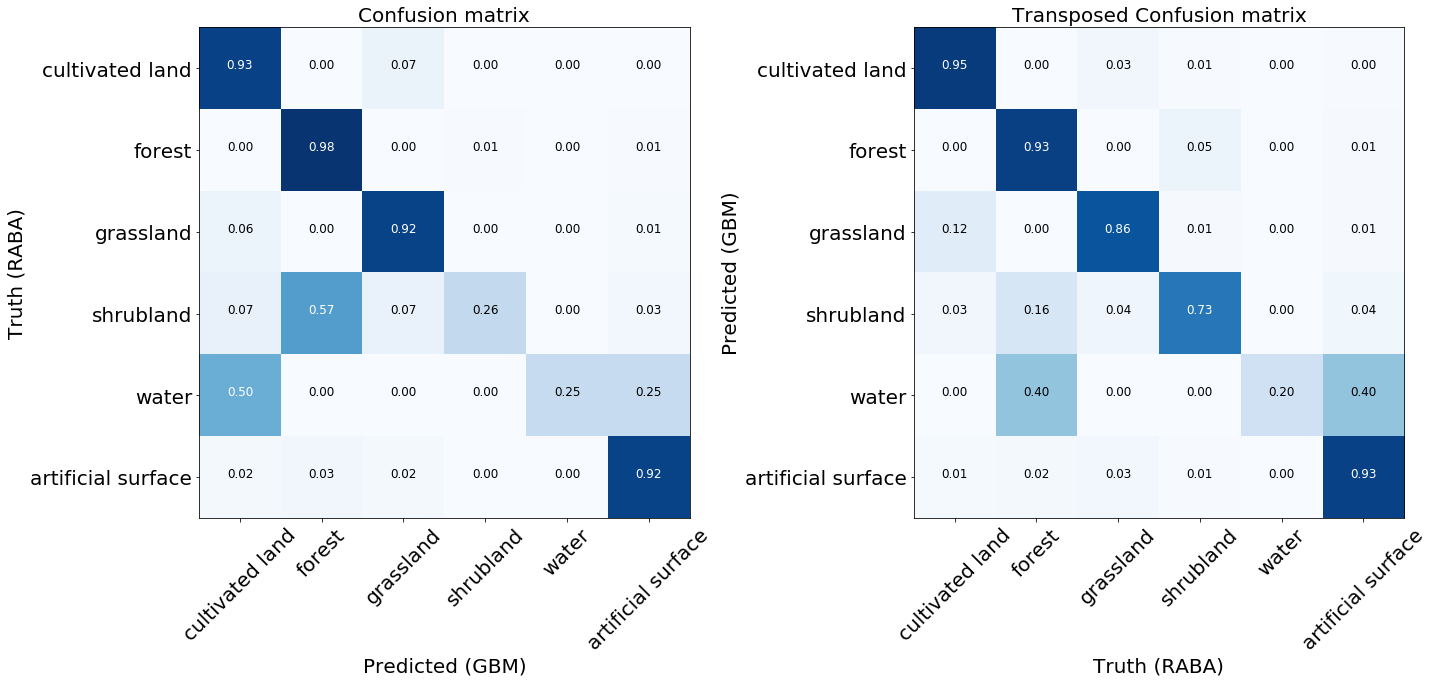

In [24]:
fig = plt.figure(figsize=(20,20))

plt.subplot(1,2,1)
conf_matrix_gbm = metrics.confusion_matrix(labels_test, plabels_test)
plot_confusion_matrix(conf_matrix_gbm, 
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels], 
                      normalize=True, 
                      ylabel='Truth (RABA)', 
                      xlabel='Predicted (GBM)',
                      title='Confusion matrix');

plt.subplot(1,2,2)
conf_matrix_gbm = metrics.confusion_matrix(plabels_test, labels_test)
plot_confusion_matrix(conf_matrix_gbm, 
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels], 
                      normalize=True, 
                      xlabel='Truth (RABA)', 
                      ylabel='Predicted (GBM)',
                      title='Transposed Confusion matrix');

plt.tight_layout()

For most of the classes the model seems to perform well. Otherwise the training sample is probably too small to make a fair assesment. 
Additional problems arise due to the unbalanced training set. The image below shows the frequency of the classes used for model training, and we see that the problematic cases are all the under-represented classes: shrubland, water, wetland, and bareland. 

Improving the reference map would also affect the end result, as, for example some classes are mixed up to some level.

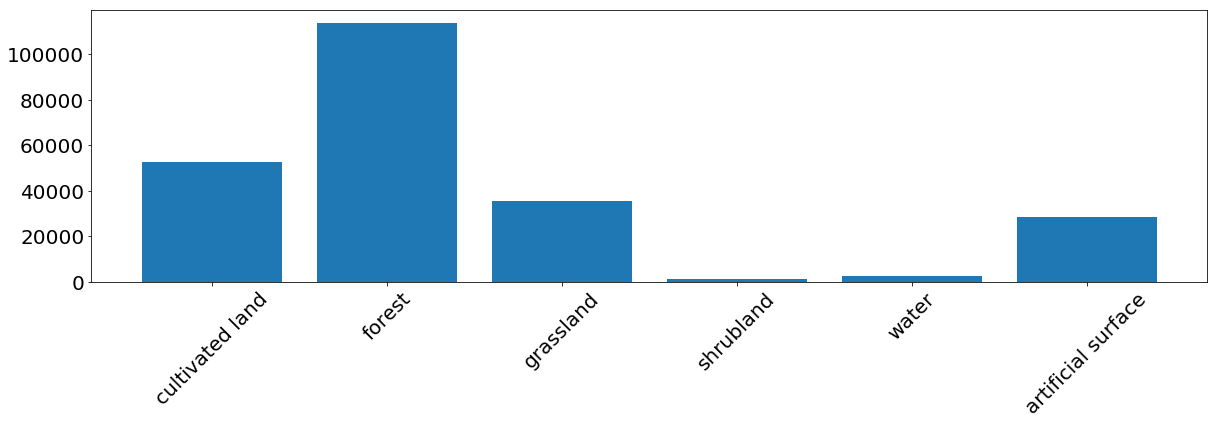

In [25]:
fig = plt.figure(figsize=(20,5))

label_ids, label_counts = np.unique(labels_train, return_counts=True)

plt.bar(range(len(label_ids)), label_counts)
plt.xticks(range(len(label_ids)), [class_names[i] for i in label_ids], rotation = 45, fontsize=20);
plt.yticks(fontsize=20);

### ROC curves and AUC metrics

Calculate precision and recall rates, draw ROC curves and calculate AUC.

In [26]:
class_labels = np.unique(np.hstack([labels_test,labels_train]))

scores_test = model.predict_proba(features_test)
labels_binarized = preprocessing.label_binarize(labels_test, classes=class_labels)

fpr = dict()
tpr = dict()
roc_auc = dict()

for idx,lbl in enumerate(class_labels):
    fpr[idx], tpr[idx], _ = metrics.roc_curve(labels_binarized[:, idx], scores_test[:, idx])
    roc_auc[idx] = metrics.auc(fpr[idx], tpr[idx])    

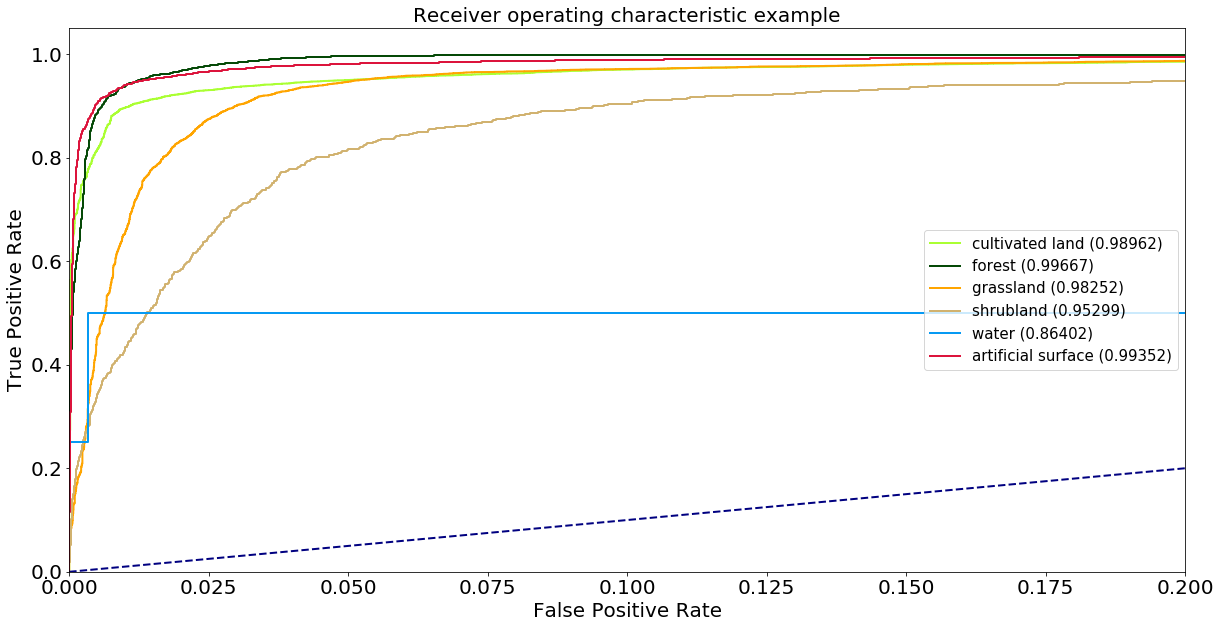

In [27]:
plt.figure(figsize=(20,10))

for idx,lbl in enumerate(class_labels):
    if np.isnan(roc_auc[idx]):
        continue
    plt.plot(fpr[idx], tpr[idx], color=lulc_cmap.colors[lbl],
         lw=2, label=class_names[lbl]+' (%0.5f)' % roc_auc[idx])
    

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 0.2])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Receiver operating characteristic example', fontsize=20)
plt.legend(loc="center right", prop={'size':15})
plt.show()

### Most important features

Let us now check which features are most important in the above classification. The LightGBM model already contains the information about feature importances, so we only need to query them. 

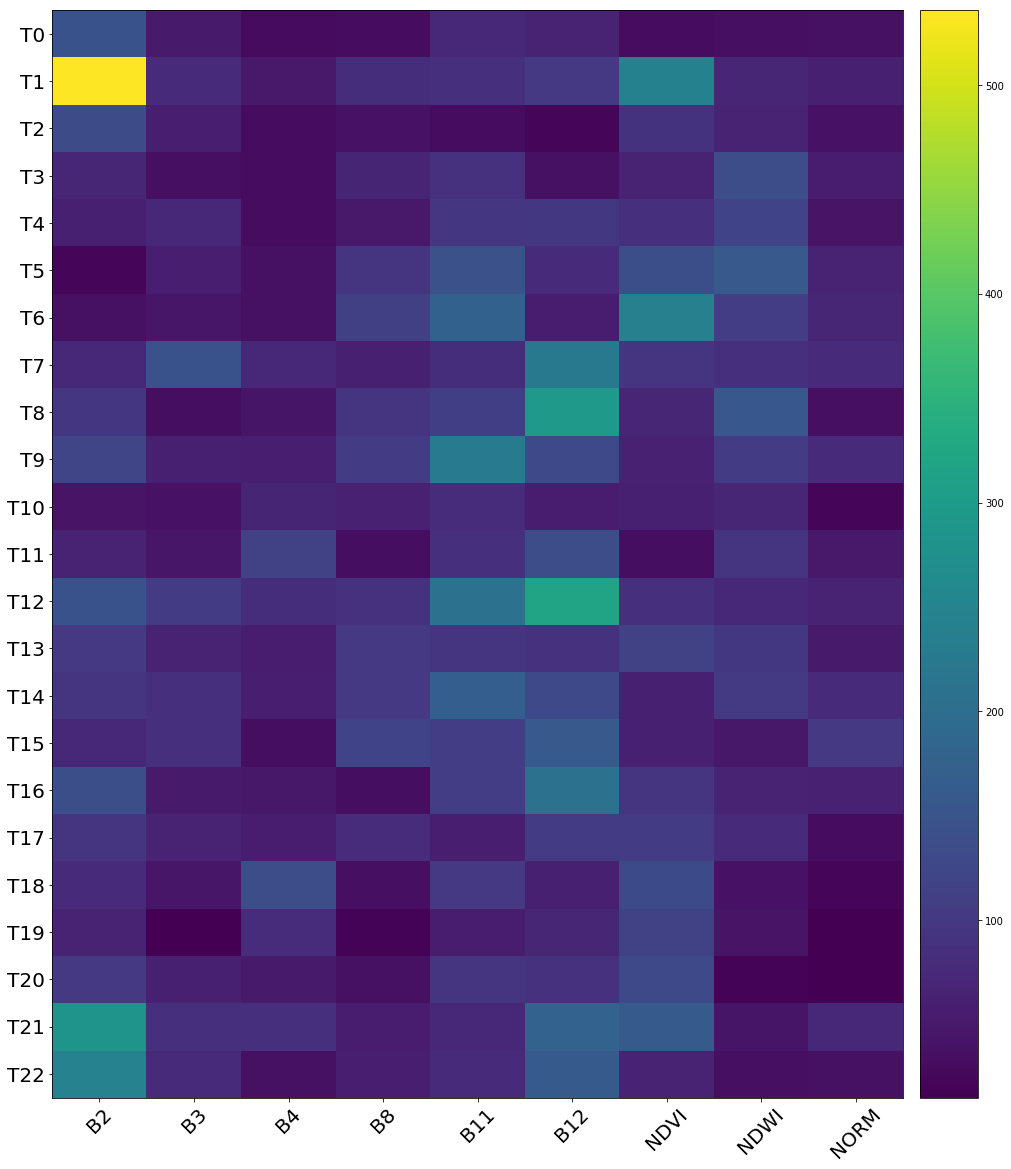

In [28]:
# names of features
fnames = ['B2','B3','B4','B8','B11','B12','NDVI','NDWI','NORM']

# get feature importances and reshape them to dates and features
z = np.zeros(t*f)
z = model.feature_importances_
z = z.reshape((t,f))

fig = plt.figure(figsize=(20,20))
ax = plt.gca()

# plot the importances
im = ax.imshow(z,aspect=0.5)
plt.xticks(range(len(fnames)), fnames, rotation = 45, fontsize=20)
plt.yticks(range(t), ['T{}'.format(i) for i in range(t)], fontsize=20)

cax = fig.add_axes([0.82, 0.125, 0.04, 0.755]) 
plt.colorbar(im, cax=cax)

We see that the most important features are from time frame `T1` (in this case `B2` and `NDVI`). If we look at the image for that time, we see that it is covered in snow, as shown below. It seems that snow cover provides useful information for land-use-land-cover classification.

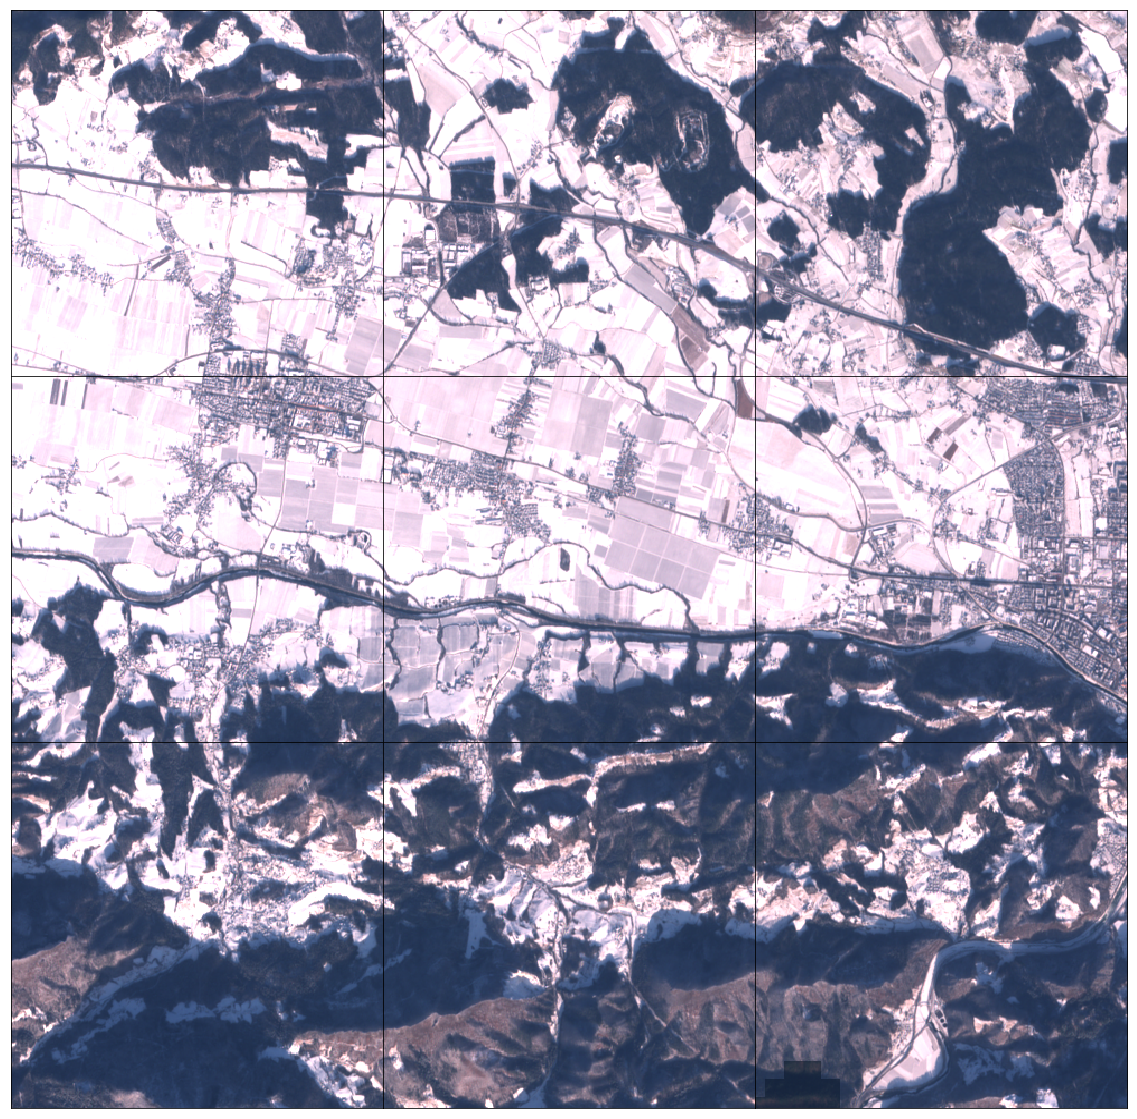

In [29]:
# Draw the RGB image
path_out = './eopatches_sampled_small/' if use_smaller_patches else './eopatches_sampled_large/'
fig = plt.figure(figsize=(20,20*aspect_ratio))

pbar = tqdm(total=9)
for i in range(9):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i)) if save_choice else eopatches[i]
    ax = plt.subplot(3,3,i+1)
    plt.imshow(np.clip(eopatch.data['FEATURES'][1][...,[2,1,0]]*2.5,0,1))
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

We can also check by comparing histograms for each class for `B2` and for `NDVI` on different dates. Left are the histograms for the date `T19` and for `T1` on the right. We see that for the optimal time `T1`, the feature distributions are more localized and separatable then on a non-optimal time, so snow cover really does seem to help.

In [30]:
b2_t1 = np.swapaxes(np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches]), 1, 3)[...,1,0].reshape(p*h*w)
b2_t22 = np.swapaxes(np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches]), 1, 3)[...,19,0].reshape(p*h*w)
ndvi_t1 = np.swapaxes(np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches]), 1, 3)[...,1,6].reshape(p*h*w)
ndvi_t22 = np.swapaxes(np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches]), 1, 3)[...,19,6].reshape(p*h*w)
labels = np.array([eopatch.mask_timeless['LULC_SAMPLED'] for eopatch in eopatches]).reshape(p*h*w*1)

# remove nans
mask = np.any([np.isnan(b2_t1), np.isnan(b2_t22), np.isnan(ndvi_t1), np.isnan(ndvi_t22), labels==0],axis=0)
b2_t1, b2_t22, ndvi_t1, ndvi_t22, labels = [array[~mask] for array in [b2_t1, b2_t22, ndvi_t1, ndvi_t22, labels]]

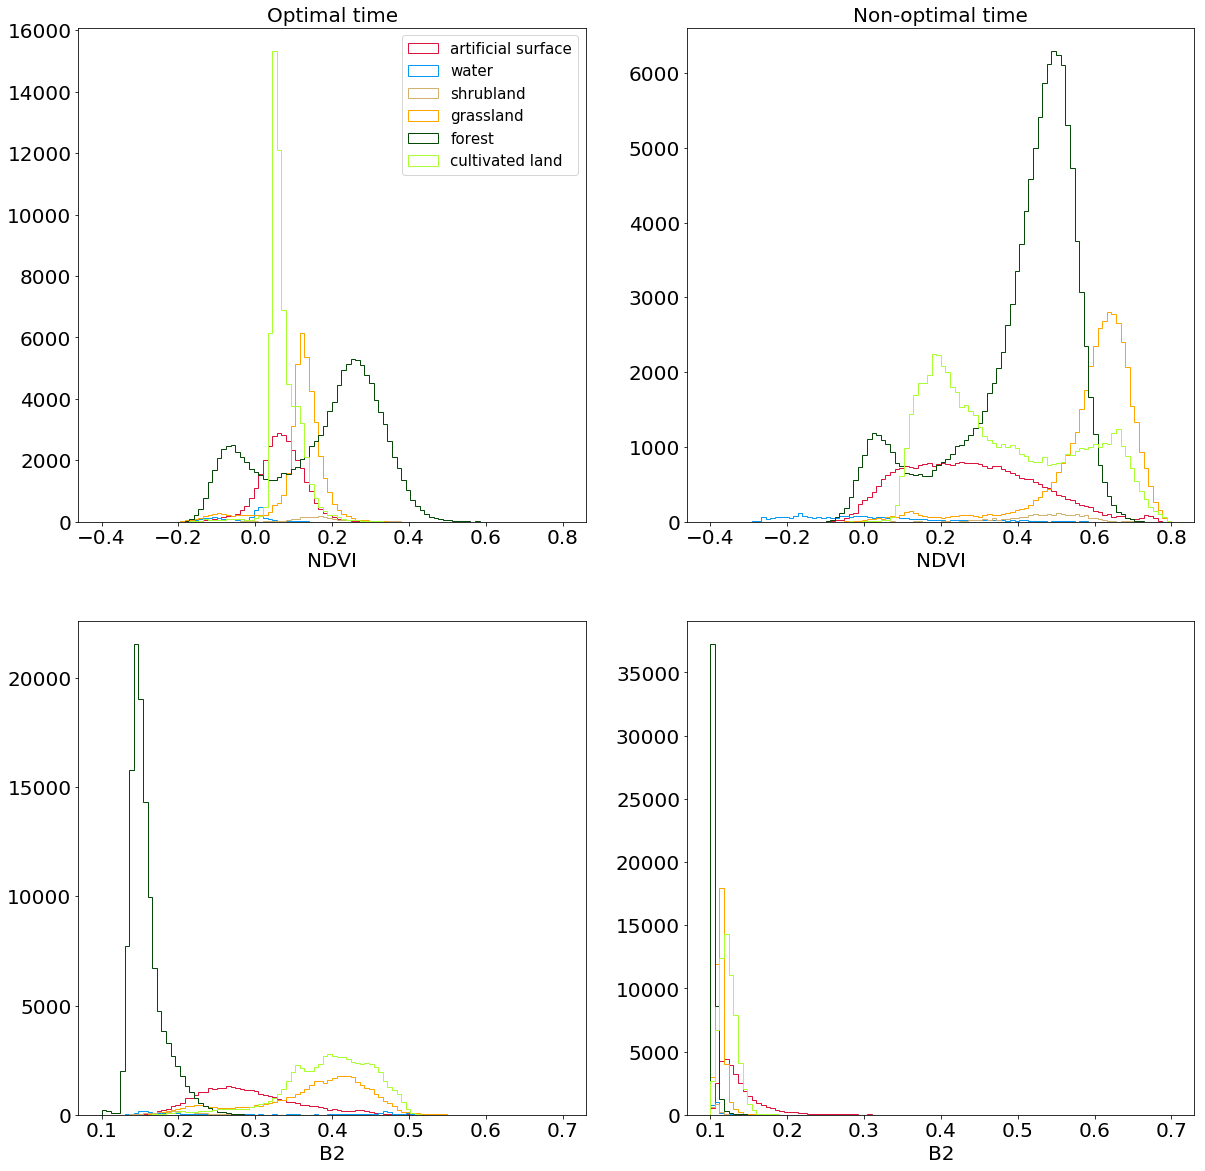

In [31]:
fig = plt.figure(figsize=(20,20))

plot_labels = np.unique(labels)
plot_colors = lulc_cmap.colors

plt.subplot(2,2,1)
plt.hist([ndvi_t1[labels == i] for i in plot_labels],100,(-0.4, 0.8),histtype='step', 
         color=[plot_colors[i] for i in plot_labels],
         label=[class_names[i] for i in plot_labels],
        );
plt.title('Optimal time', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('NDVI', fontsize=20)
plt.legend(loc=1, prop={'size':15})

plt.subplot(2,2,2)
plt.hist([ndvi_t22[labels == i] for i in np.unique(labels)],100,(-0.4, 0.8),histtype='step', 
         color=[plot_colors[i] for i in plot_labels],
        );
plt.title('Non-optimal time', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('NDVI', fontsize=20)

plt.subplot(2,2,3)
plt.hist([b2_t1[labels == i] for i in np.unique(labels)],100,(0.1, 0.7),histtype='step', 
         color=[plot_colors[i] for i in plot_labels],
        );
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('B2', fontsize=20)

plt.subplot(2,2,4)
plt.hist([b2_t22[labels == i] for i in np.unique(labels)],100,(0.1, 0.7),histtype='step', 
         color=[plot_colors[i] for i in plot_labels],
        );
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('B2', fontsize=20);

## 9. Visualization of the results

The model has been validated, the remaining thing is to make the prediction on the whole AOI.

We only need to load all the pixels and reshape them in the proper form in order for the model to make the prediction, and then reshape it back to draw it.

In [32]:
# load all features and get shape
features = np.array([eopatch.data['FEATURES'] for eopatch in eopatches])
p, t, w, h, f = features.shape

# reshape features into the format that the model accepts
features = np.swapaxes(features,1,3).reshape(p*h*w,t*f)

# predict labels and reshape them to visualize them
plabels = model.predict(features)
plabels = np.swapaxes(plabels.reshape(p,h,w),1,2)

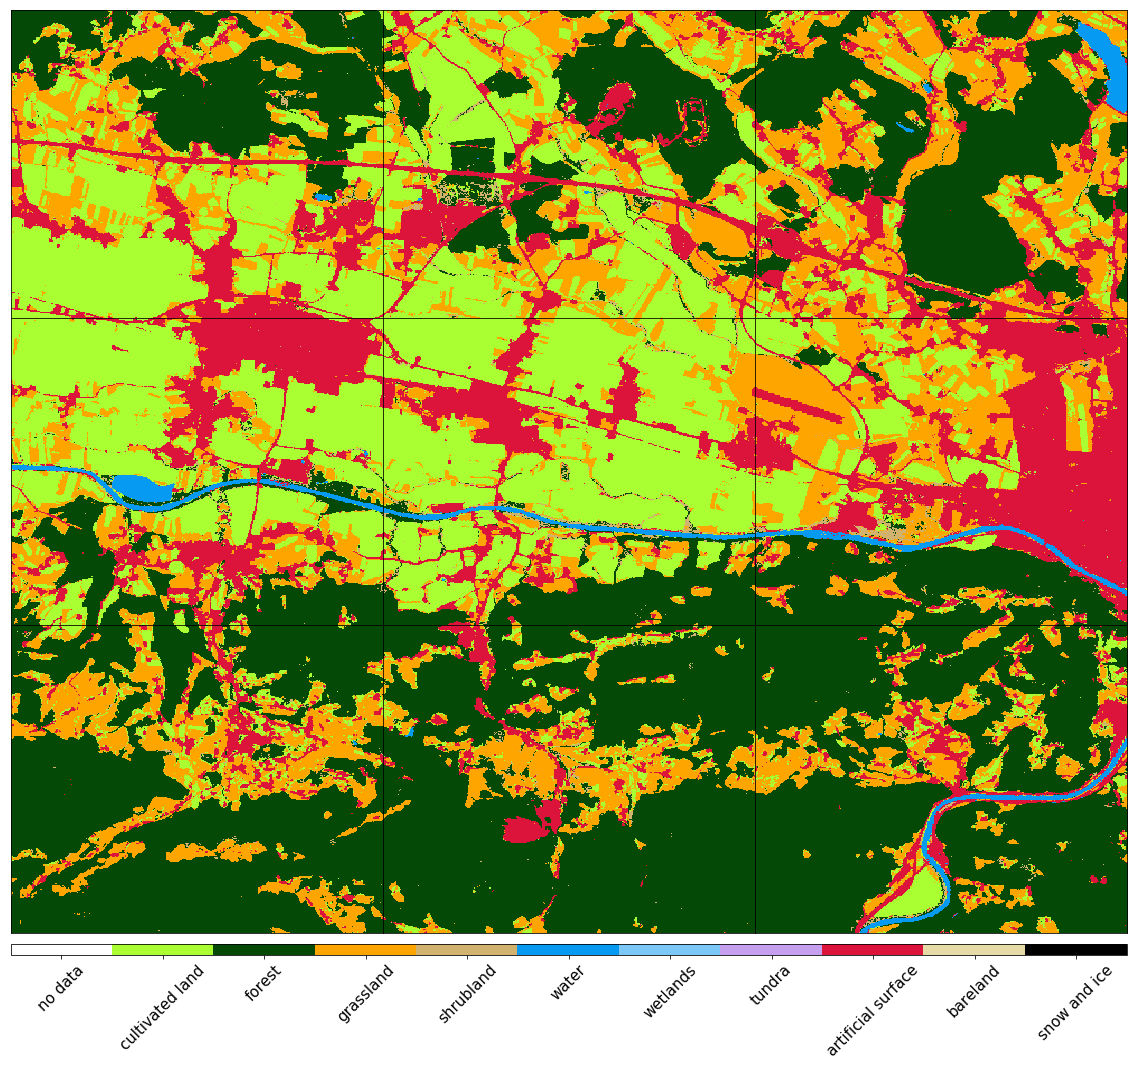

In [33]:
# Draw the Prediction map
fig, axes = plt.subplots(figsize=(20,20*aspect_ratio), nrows=3, ncols=3)

for i, ax in enumerate(axes.flat):
    im = ax.imshow(plabels[i], cmap=lulc_cmap, norm=lulc_norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad = 0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
cb.set_ticks(np.array(list(lulc_classes.values())))
cb.ax.set_xticklabels(list(lulc_classes.keys()),rotation=45,fontsize=15)
plt.show()

### Visual inspection of patches

Here is just a simple piece of code that allows a closer inspection of the predicted labels. 

Random subsets of patches are chosen, where prediction and ground truth are compared. For visual aid the mask of differences and the true color image are also provided.

In majority of the cases, differences seem to lie on the border of different structures.

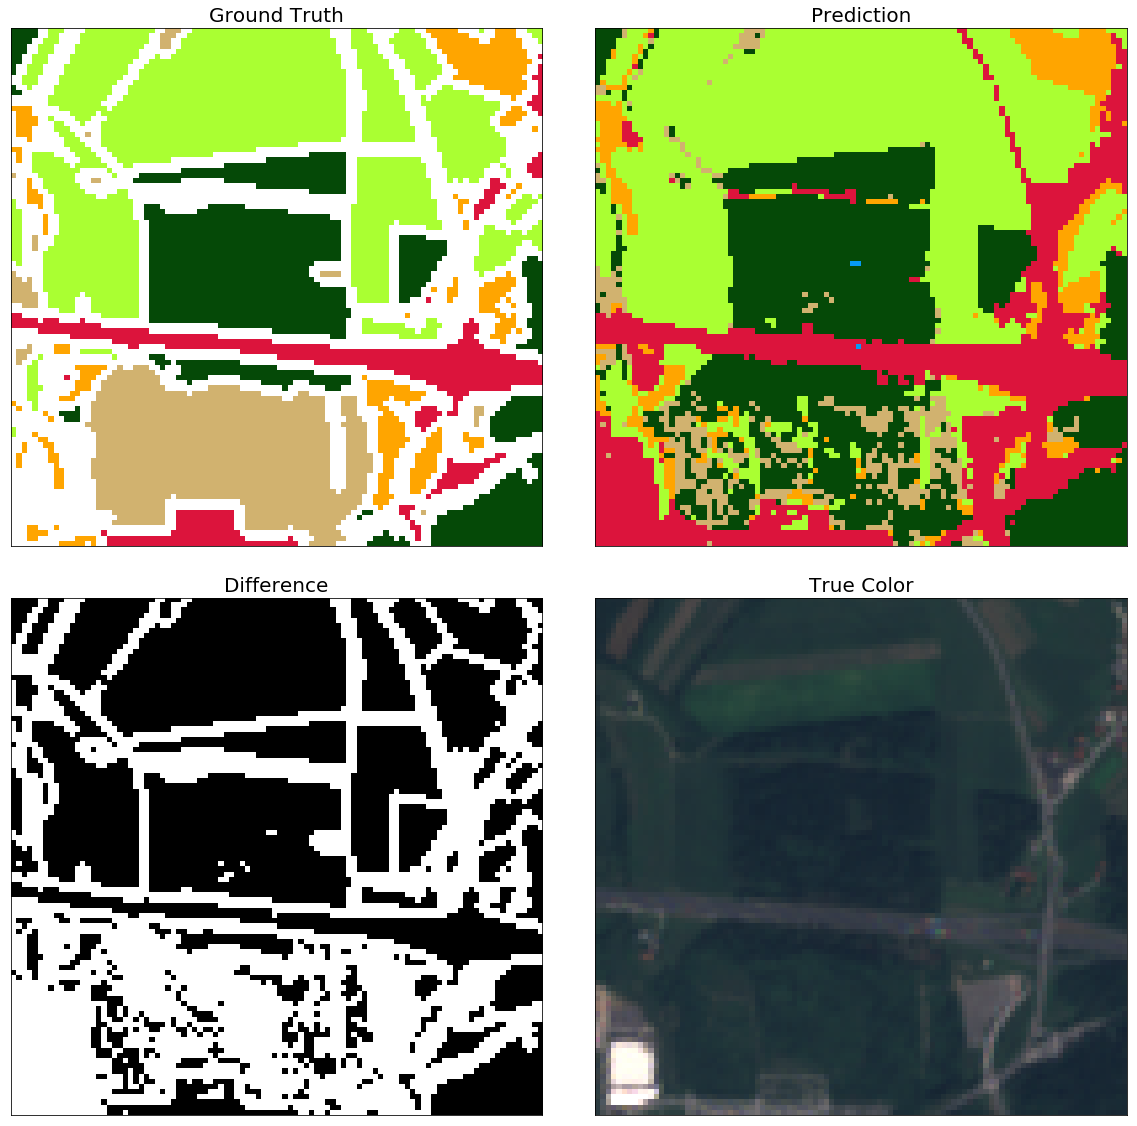

In [34]:
# Draw the Reference map

fig = plt.figure(figsize=(20,20))

idx = np.random.choice(range(9))
inspect_size = 100

w_min = np.random.choice(range(w-inspect_size))
h_min = np.random.choice(range(h-inspect_size))

ax = plt.subplot(2,2,1)
plt.imshow(eopatches[idx].mask_timeless['LULC'].squeeze()[w_min:w_min+inspect_size,h_min:h_min+inspect_size], cmap=lulc_cmap, norm=lulc_norm)
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title('Ground Truth', fontsize=20)

ax = plt.subplot(2,2,2)
plt.imshow(plabels[idx][w_min:w_min+inspect_size,h_min:h_min+inspect_size], cmap=lulc_cmap, norm=lulc_norm)
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title('Prediction', fontsize=20)

ax = plt.subplot(2,2,3)
mask = plabels[idx] != eopatches[idx].mask_timeless['LULC'].squeeze()
plt.imshow(mask[w_min:w_min+inspect_size,h_min:h_min+inspect_size], cmap='gray')
plt.xticks([])
plt.yticks([]);
ax.set_aspect("auto")
plt.title('Difference', fontsize=20)

ax = plt.subplot(2,2,4)
image = np.clip(eopatches[idx].data['FEATURES'][15][...,[2,1,0]]*2.5,0,1)
plt.imshow(image[w_min:w_min+inspect_size,h_min:h_min+inspect_size])
plt.xticks([])
plt.yticks([]);
ax.set_aspect("auto")
plt.title('True Color', fontsize=20)

fig.subplots_adjust(wspace=0.1, hspace=0.1)